In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [29]:
with open("details/ped_dataset.pkl", 'rb') as f:
    ped_dataset = pickle.load(f)
    
total_ped_matrix = np.load("details/total_ped_matrix.npy")

with open("details/trajectories_2d.txt", 'rb') as f:
    trajectories_2d = pickle.load(f)

In [3]:
# initial uncertainty P0
P = np.diag([1000.0, 1000.0, 1000.0, 1000.0])

# dynamic matrix A (motion model)
dt = 0.5

A = np.matrix([[1.0, 0.0, dt, 0.0],
               [0.0, 1.0, 0.0, dt],
               [0.0, 0.0, 1.0, 0.0],
               [0.0, 0.0, 0.0, 1.0]])

# measurement matrix H - directly measuring velocity 
H = np.matrix([[0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 1.0]])

# measurement covariance R - tells the filter how bad the sensor readings are
ra = 10.0**2

R = np.matrix([[ra, 0.0],
              [0.0, ra]])

# process noise - impact of wind force on the acceleration (IMPORTANT?)
sv = 0.8 # have to check the value for pedestrians

G = np.matrix([[0.5*dt**2],
               [0.5*dt**2],
               [dt],
               [dt]])

Q = G*G.T*sv**2

# index matrix
I = np.eye(4)

In [4]:
# only predicting from the 3 seconds to 8 seconds
vel_measurements = total_ped_matrix[9800:, 6:, 2:4]

# initial state 
x = np.matrix([[trajectories_2d[9800,5,0], trajectories_2d[9800,5,1], 
                0.0, 0.0]]).T

In [5]:
# Preallocation for Plotting
xt = []
yt = []
dxt= []
dyt= []
Zx = []
Zy = []
Px = []
Py = []
Pdx= []
Pdy= []
Rdx= []
Rdy= []
Kx = []
Ky = []
Kdx= []
Kdy= []

def savestates(x, Z, P, R, K):
    xt.append(float(x[0]))
    yt.append(float(x[1]))
    dxt.append(float(x[2]))
    dyt.append(float(x[3]))
    Zx.append(float(Z[0]))
    Zy.append(float(Z[1]))
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Pdx.append(float(P[2,2]))
    Pdy.append(float(P[3,3]))
    Rdx.append(float(R[0,0]))
    Rdy.append(float(R[1,1]))
    Kx.append(float(K[0,0]))
    Ky.append(float(K[1,0]))
    Kdx.append(float(K[2,0]))
    Kdy.append(float(K[3,0]))

In [6]:
cur_diff = np.diff(trajectories_2d[9800,6:, :], axis=0) / 0.5
cur_diff = np.vstack((cur_diff[0], cur_diff))

In [8]:
# kalman filter
for n in range(10):
    # Time Update (Prediction)
    # ========================
    # Project the state ahead
    x = A*x
    
    # Project the error covariance ahead
    P = A*P*A.T + Q
    
    
    # Measurement Update (Correction)
    # ===============================
    # Compute the Kalman Gain
    S = H*P*H.T + R
    K = (P*H.T) * np.linalg.pinv(S)

    
    # Update the estimate via z
    Z = cur_diff[n, :].reshape(2,1)
    y = Z - (H*x)                            # Innovation or Residual
    x = x + (K*y)
    
    # Update the error covariance
    P = (I - (K*H))*P
    
    # Save states (for Plotting)
    savestates(x, Z, P, R, K)

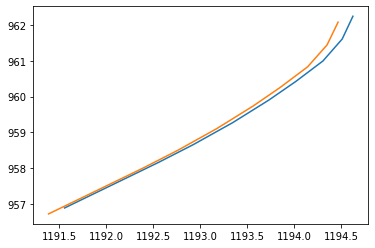

In [9]:
xy_values = [[xp, yp] for xp, yp in zip(xt, yt)]

plt.plot(*zip(*np.array(trajectories_2d[9800,6:, :])))
plt.plot(*zip(*np.array(xy_values)))

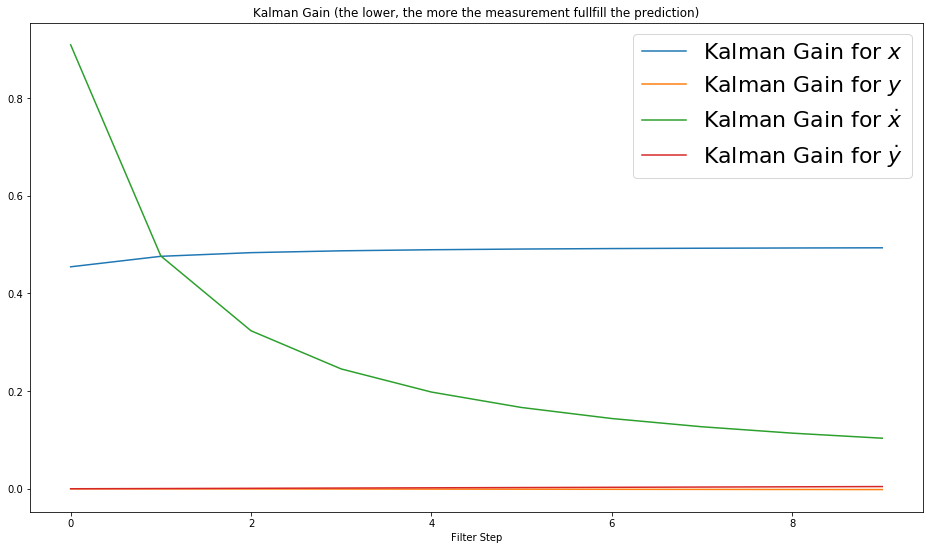

In [10]:
def plot_K():
    fig = plt.figure(figsize=(16,9))
    plt.plot(range(10),Kx, label='Kalman Gain for $x$')
    plt.plot(range(10),Ky, label='Kalman Gain for $y$')
    plt.plot(range(10),Kdx, label='Kalman Gain for $\dot x$')
    plt.plot(range(10),Kdy, label='Kalman Gain for $\dot y$')

    plt.xlabel('Filter Step')
    plt.ylabel('')
    plt.title('Kalman Gain (the lower, the more the measurement fullfill the prediction)')
    plt.legend(loc='best',prop={'size':22})

plot_K()

In [40]:
np.array(total_ped_matrix[9800,6:, :2])

array([[-4.57716149e-01,  4.40159891e+00],
       [-4.64853034e-01,  5.15083990e+00],
       [-4.64968209e-01,  5.89924686e+00],
       [-4.65535347e-01,  6.64984375e+00],
       [-4.35922639e-01,  7.38475060e+00],
       [-3.78448678e-01,  8.21034236e+00],
       [-3.20974718e-01,  9.03593411e+00],
       [-2.22161636e-01,  9.81389103e+00],
       [-1.23348554e-01,  1.05918480e+01],
       [-1.77635684e-15,  1.13305747e+01]])

In [20]:

    
trajectories_2d.shape

(12317, 16, 2)

In [4]:
trajectories_2d[9800, :, :2]

array([[1188.419,  953.111],
       [1188.929,  953.762],
       [1189.402,  954.337],
       [1189.874,  954.911],
       [1190.391,  955.537],
       [1190.927,  956.145],
       [1191.554,  956.89 ],
       [1192.056,  957.527],
       [1192.557,  958.163],
       [1192.93 ,  958.663],
       [1193.347,  959.272],
       [1193.732,  959.901],
       [1194.018,  960.418],
       [1194.309,  960.993],
       [1194.514,  961.605],
       [1194.628,  962.24 ]])

In [7]:
with open("details/new_ped_details.pkl", 'rb') as f:
    new_ped_details = pickle.load(f)

In [8]:
len(new_ped_details)

5659

In [9]:
new_ped_details.keys()

dict_keys(['739041c5fc6c43b8b9ef0612e7b0b2f7', 'd395df80fd304d5993360b6b0d93e8c2', 'ef3ba2c47e8b4b36a956b7049c5b575c', 'a261a4e2cd964e4d8812e76ed69da7a6', 'c4c6aba8a028437a977e608d195d99f3', '191e8daaacc142b087460fb78e72f442', 'a721d524937f4a228fa6aac3296fb3bc', '069a7d8902d14560b1890064b43a1a15', '7d64812f02a14f1badd236c35d9f6390', '24082a541e824068815c8b6824360b39', 'c4655acf4f2b4dab817413eb13a9e22c', 'e345640c7dfa4294b644d6c04b69cd70', 'f767b77d7595416dae214ad03385453e', '4c41ca5fe6bf4e2b9f8c2225403ec3f5', 'ed71fa49b49c47aaa8f1de7880332ac8', '242f8b7b6b834ca6853fb7ffc9ce37df', '88dbfeb04e6c4b26bbef530d1c947982', 'd06ef3ae090e4791a63d98fe6b9c885b', 'f59ab2e5cc374c9a856ec24d6e41a90a', '0a374458cdb04efa9bff8a0a8e97667a', '6eba15833c7641dfb9d11806f1ba5c14', '460ccf4388fc4af08984af9d1ec10dda', 'acb2c4d8335344ad8a5a504513b6f40f', '6b08b56b68f949ec8b418cceb68570db', 'd95de0e07d9f4c82803d8091804d4f66', 'fb35c9b4468f49b89ba0ed569c3ae779', '622507bb790b40029dac2bea76b5c7f0', '443a37682e4d4157

In [16]:
new_ped_details['739041c5fc6c43b8b9ef0612e7b0b2f7']['translation']

[[994.471, 613.661, 1.26],
 [994.526, 613.677, 1.33],
 [994.433, 613.889, 1.305],
 [994.379, 614.114, 1.28],
 [994.205, 614.48, 1.255],
 [994.238, 614.885, 1.28],
 [993.972, 615.248, 1.28],
 [993.877, 615.888, 1.28],
 [993.827, 616.539, 1.38],
 [993.776, 617.191, 1.33],
 [993.725, 617.842, 1.33],
 [993.704, 618.521, 1.33],
 [993.682, 619.2, 1.33],
 [993.66, 619.879, 1.33],
 [993.639, 620.558, 1.33],
 [993.462, 621.19, 1.33],
 [993.419, 621.834, 1.355],
 [993.225, 622.45, 1.38],
 [992.916, 622.998, 1.33],
 [992.607, 623.546, 1.33],
 [992.243, 624.184, 1.364],
 [991.601, 624.541, 1.397],
 [991.122, 624.877, 1.43]]

In [15]:
new_ped_details['739041c5fc6c43b8b9ef0612e7b0b2f7']['velocity']

[[0.10092522149915945, 0.03000479558084795, 0.07001118968861257],
 [-0.03453298782338384, 0.20719792694030303, 0.040894327685574314],
 [-0.16329036165726318, 0.4854278098248825, -0.055540939339229954],
 [-0.25358495177034507, 0.6573188881417004, -0.05561073503736818],
 [-0.14111486199824944, 0.7716280751820793, 0.0],
 [-0.23318374258744887, 0.768605640803093, 0.025019714869891536],
 [-0.3612864930334721, 1.0037959903392906, 0.0],
 [-0.14503700008154177, 1.2913294283123118, 0.10002551729762743],
 [-0.10102596521150928, 1.303334976936609, 0.0500128540651041],
 [-0.10743253132490896, 1.372397924670488, -0.05266300555143845],
 [-0.0757896410663135, 1.4000030919192725, 0.0],
 [-0.04298612327316161, 1.357561753603429, 0.0],
 [-0.04192400269148862, 1.2939271739787832, 0.0],
 [-0.037386456885522446, 1.1807164755937207, 0.0],
 [-0.17984744441324074, 1.1908080789181308, 0.0],
 [-0.21993466410842785, 1.275621051828677, 0.024992575466863613],
 [-0.2370592887863626, 1.2603152062061482, 0.0500125081

In [21]:
np.diff(np.array(new_ped_details['739041c5fc6c43b8b9ef0612e7b0b2f7']['translation']), axis=0) / 0.5

array([[ 0.11 ,  0.032,  0.14 ],
       [-0.186,  0.424, -0.05 ],
       [-0.108,  0.45 , -0.05 ],
       [-0.348,  0.732, -0.05 ],
       [ 0.066,  0.81 ,  0.05 ],
       [-0.532,  0.726,  0.   ],
       [-0.19 ,  1.28 ,  0.   ],
       [-0.1  ,  1.302,  0.2  ],
       [-0.102,  1.304, -0.1  ],
       [-0.102,  1.302,  0.   ],
       [-0.042,  1.358,  0.   ],
       [-0.044,  1.358,  0.   ],
       [-0.044,  1.358,  0.   ],
       [-0.042,  1.358,  0.   ],
       [-0.354,  1.264,  0.   ],
       [-0.086,  1.288,  0.05 ],
       [-0.388,  1.232,  0.05 ],
       [-0.618,  1.096, -0.1  ],
       [-0.618,  1.096,  0.   ],
       [-0.728,  1.276,  0.068],
       [-1.284,  0.714,  0.066],
       [-0.958,  0.672,  0.066]])

In [24]:
ped_dataset[10]['translation']

[[373.912, 1083.45, 0.756],
 [374.099, 1083.961, 0.791],
 [374.308, 1084.462, 0.826],
 [374.54, 1084.954, 0.86],
 [374.794, 1085.434, 0.895],
 [375.069, 1085.902, 0.929],
 [375.425, 1086.311, 0.958],
 [375.823, 1086.678, 0.986],
 [376.261, 1086.998, 1.015],
 [376.731, 1087.267, 1.043],
 [377.228, 1087.482, 1.071],
 [377.577, 1087.918, 1.111],
 [377.862, 1088.398, 1.152],
 [378.33, 1088.718, 1.117],
 [378.619, 1089.263, 1.132],
 [378.839, 1089.569, 1.147]]

In [25]:
ped_dataset[10]['velocity']

[[0.3740927582904628, 1.0222534731893163, 0.07001736117735498],
 [0.39609821466048, 1.0122509930211319, 0.07001736117735487],
 [0.44135398359321054, 0.9937970650975058, 0.06905538518804845],
 [0.48610500219629954, 0.9722100043925991, 0.06901490771922919],
 [0.48050108929819413, 0.8610870182509183, 0.06267405512585189],
 [0.5734539515280415, 0.7970192004596552, 0.057254514970308944],
 [0.7541787313601527, 0.776183946333632, 0.057013511521924146],
 [0.8366700455386681, 0.6875506235468436, 0.057045684923090076],
 [1.0092745917442414, 0.6546946415608914, 0.06335754595751181],
 [1.074181965339212, 0.5376464025068303, 0.06220702177765965],
 [0.8452714747473725, 0.6504393972345175, 0.0679414424146822],
 [0.6331085198121191, 0.9147119939240533, 0.08088610426621522],
 [0.7917248858905203, 0.8411419770419284, 0.006308564827813034],
 [0.7563329821346056, 0.8642378197443018, -0.019982377335128174],
 [0.48497897705796505, 0.810839114884599, 0.02858422261638222],
 [0.5361415034876175, 0.744196415289

In [26]:
np.diff(np.array(ped_dataset[10]['translation']), axis=0)  / 0.5

array([[ 0.374,  1.022,  0.07 ],
       [ 0.418,  1.002,  0.07 ],
       [ 0.464,  0.984,  0.068],
       [ 0.508,  0.96 ,  0.07 ],
       [ 0.55 ,  0.936,  0.068],
       [ 0.712,  0.818,  0.058],
       [ 0.796,  0.734,  0.056],
       [ 0.876,  0.64 ,  0.058],
       [ 0.94 ,  0.538,  0.056],
       [ 0.994,  0.43 ,  0.056],
       [ 0.698,  0.872,  0.08 ],
       [ 0.57 ,  0.96 ,  0.082],
       [ 0.936,  0.64 , -0.07 ],
       [ 0.578,  1.09 ,  0.03 ],
       [ 0.44 ,  0.612,  0.03 ]])

In [27]:
total_ped_matrix[10,:,2:4]

array([[0.37409276, 1.02225347],
       [0.39609821, 1.01225099],
       [0.44135398, 0.99379707],
       [0.486105  , 0.97221   ],
       [0.48050109, 0.86108702],
       [0.57345395, 0.7970192 ],
       [0.75417873, 0.77618395],
       [0.83667005, 0.68755062],
       [1.00927459, 0.65469464],
       [1.07418197, 0.5376464 ],
       [0.84527147, 0.6504394 ],
       [0.63310852, 0.91471199],
       [0.79172489, 0.84114198],
       [0.75633298, 0.86423782],
       [0.48497898, 0.81083911],
       [0.5361415 , 0.74419642]])